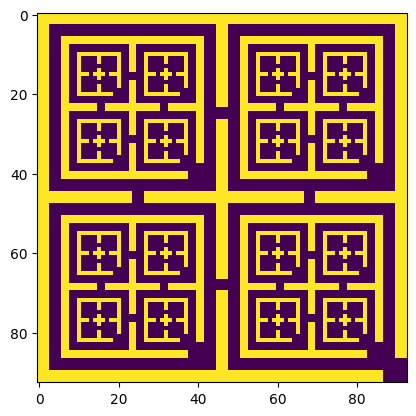

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
import hypll
from hypll.manifolds.poincare_ball import Curvature, PoincareBall
from hypll.optim import RiemannianAdam
import hypll.nn as hnn
from hypll.tensors import TangentTensor
from matplotlib.animation import FuncAnimation
import argparse
from environments.maze.pyramid import create_pyramid
from environments.maze.continuous_maze import bfs, gen_traj, plot_traj, ContinuousGridEnvironment
from environments.maze.data import TrajectoryDataset, LabelDataset
from networks.hypnets import HyperbolicMLP, manifold_map
from networks.nets import SmallEncoder
from utils import get_maze, load_model
import os
import json

In [2]:
device = "cuda" if torch.cuda.is_available() else "cpu"

In [3]:
saved = '/home/yongweic/hyperbolic/saved_models/experiment2_hyperbolic_True_curvature_1.0_epochs_128_trajectories_10000_order__maze_blocker_embeddingdim_8_gamma_0.1_batch_128'
config = json.load(open(os.path.join(saved, 'config.json')))
print(config)

model_dict = load_model(config, device, pretrained_path=saved, epoch=33)

encoder1 = model_dict['encoder1']
encoder2 = model_dict['encoder2']
optimizer = model_dict['optimizer']
manifold = model_dict['manifold']

{'project': 'temp', 'custom': '2', 'hyperbolic': True, 'embedding_dim': 8, 'curvature': 1.0, 'num_epochs': 128, 'num_trajectories': 10000, 'batch_size': 128, 'num_negatives': 64, 'max_steps': 100, 'num_workers': 24, 'learning_rate': 0.01, 'maze_type': 'blocker', 'gamma': 0.1, 'order_name': '', 'eval_trials': 10, 'temperature': 0.1, 'architecture': 'MLP'}


/home/yongweic/.conda/envs/hypll/lib/python3.10/site-packages/torch/cuda/__init__.py:619: UserWarning: Can't initialize NVML
  warnings.warn("Can't initialize NVML")


loading pretrained...


/home/yongweic/.conda/envs/hypll/lib/python3.10/site-packages/torch/_compile.py:24: UserWarning: optimizer contains a parameter group with duplicate parameters; in future, this will cause an error; see github.com/pytorch/pytorch/issues/40967 for more information
  return torch._dynamo.disable(fn, recursive)(*args, **kwargs)


In [5]:
encoder1

HyperbolicMLP(
  (manifold): PoincareBall(
    (c): Curvature()
  )
  (euc_layer1): Linear(in_features=4, out_features=64, bias=True)
  (euc_layer2): Linear(in_features=64, out_features=64, bias=True)
  (euc_relu): ReLU()
  (hyp_layer1): HLinear(
    (manifold): PoincareBall(
      (c): Curvature()
    )
  )
  (hyp_layer2): HLinear(
    (manifold): PoincareBall(
      (c): Curvature()
    )
  )
  (hyp_relu): HReLU(
    (manifold): PoincareBall(
      (c): Curvature()
    )
  )
)

In [2]:
hyperbolic = False
maze_type = 'fork'
maze = get_maze(maze_type)

embedding_dim = 8
num_categories = 30
temp = 1.0

e1_path = f'models/experimentstreet_hyperbolic_False_epochs_512_temp_1.0_trajectories_10000_order__maze_{maze_type}_embeddingdim_8_gamma_0.1_batch_512_hyp_layers_2_encoder1_epoch_385.pth'
e2_path = f'models/experimentstreet_hyperbolic_False_epochs_512_temp_1.0_trajectories_10000_order__maze_{maze_type}_embeddingdim_8_gamma_0.1_batch_512_hyp_layers_2_encoder2_epoch_385.pth'
e3_path = f'models/experimentstreet_hyperbolic_False_epochs_512_temp_1.0_trajectories_10000_order__maze_{maze_type}_embeddingdim_8_gamma_0.1_batch_512_hyp_layers_2_street_encoder_epoch_385.pth'




# e1_path = f'models/experiment1_hyperbolic_False_epochs_256_temp_{temp}_trajectories_10000_order__maze_{maze_type}_embeddingdim_{embedding_dim}_gamma_0.1_batch_128_hyp_layers_2_encoder1_epoch_193.pth'
# e2_path = f'models/experiment1_hyperbolic_False_epochs_256_temp_{temp}_trajectories_10000_order__maze_{maze_type}_embeddingdim_{embedding_dim}_gamma_0.1_batch_128_hyp_layers_2_encoder2_epoch_193.pth'
# e3_path = f'models/experiment1_hyperbolic_False_epochs_256_temp_{temp}_trajectories_10000_order__maze_{maze_type}_embeddingdim_{embedding_dim}_gamma_0.1_batch_128_hyp_layers_2_street_encoder_epoch_193.pth'

device = "cuda" if torch.cuda.is_available() else "cpu"

manifold = PoincareBall(c=Curvature(value=0.1, requires_grad=True))

encoder1 = StateActionEncoder(embedding_dim).to(device)
encoder2 = StateEncoder(embedding_dim).to(device)
encoder3 = CategoricalEncoder(num_categories, embedding_dim)

encoder1.load_state_dict(torch.load(e1_path, map_location=torch.device(device)))
encoder2.load_state_dict(torch.load(e2_path, map_location=torch.device(device)))
encoder3.load_state_dict(torch.load(e3_path, map_location=torch.device(device)))

<All keys matched successfully>

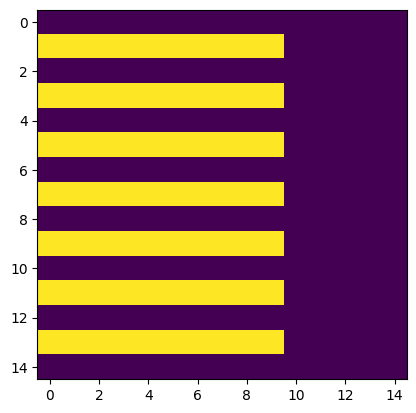

In [3]:
plt.imshow(maze)

In [4]:
valid_indices = np.argwhere(maze == 0)
valid_indices = valid_indices + 0.5

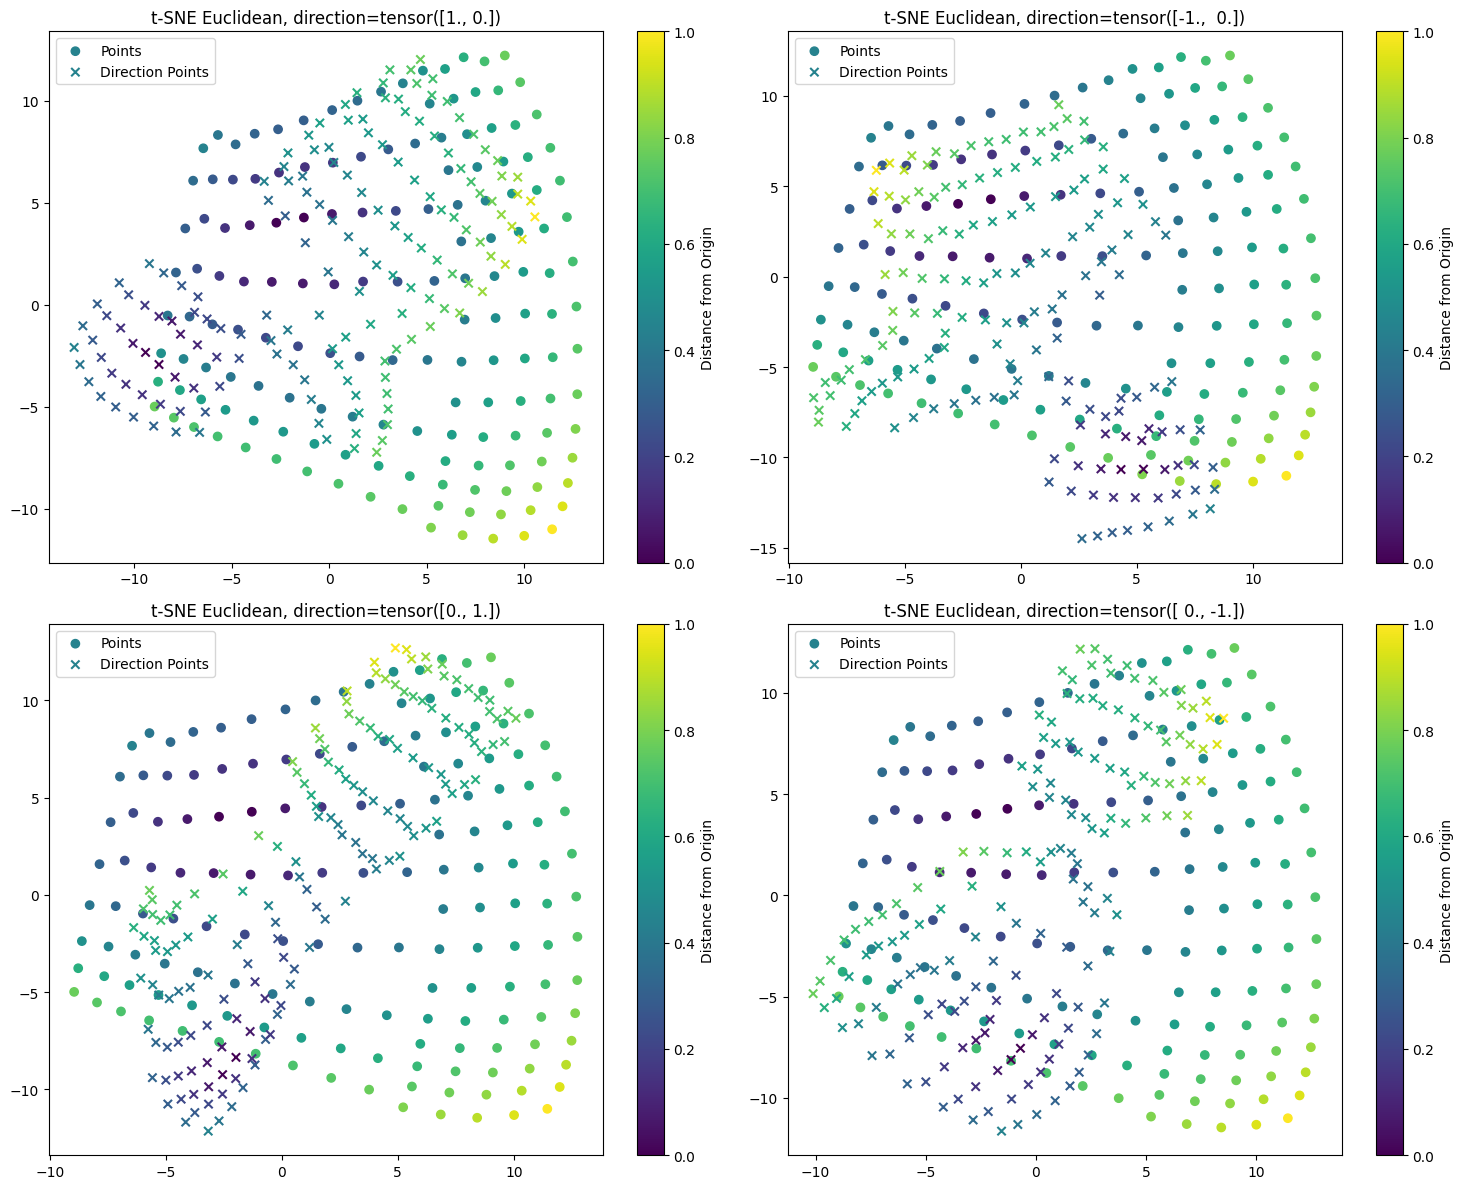

In [5]:
import torch
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.patches as patches
from sklearn.manifold import TSNE

def plot(ax, maze, direction, encoder1, encoder2, manifold, hyperbolic, device):
    with torch.no_grad():
        points = []
        valid_indices = np.argwhere(maze == 0)
        valid_indices = valid_indices + 0.5
        grid = valid_indices
        
        for p in grid:
            v = torch.tensor(p).to(device, torch.float32)
            v = encoder2(v)
            if hyperbolic:
                v = manifold.project(v)
                v = v.tensor
            points.append(v.cpu().detach().numpy())
        dir_points = []
        for p in grid:
            v = torch.stack([torch.tensor(p), direction]).flatten().to(device, torch.float32)
            v = encoder1(v)
            if hyperbolic:
                v = manifold.project(v)
                v = v.tensor
            dir_points.append(v.cpu().detach().numpy())
    
    points = np.array(points)
    dir_points = np.array(dir_points)
    
    # Perform t-SNE on points and dir_points
    tsne = TSNE(n_components=2, random_state=42)
    points_tsne = tsne.fit_transform(points)
    dir_points_tsne = tsne.fit_transform(dir_points)
    
    # Compute distances from origin
    distances_points = torch.norm(torch.tensor(grid) - torch.tensor([5., 5.]), dim=1).numpy()
    distances_dir_points = torch.norm(torch.tensor(grid) - torch.tensor([5., 5.]), dim=1).numpy()
    
    # Normalize distances for colormap
    norm_distances_points = (distances_points - distances_points.min()) / (distances_points.max() - distances_points.min())
    norm_distances_dir_points = (distances_dir_points - distances_dir_points.min()) / (distances_dir_points.max() - distances_dir_points.min())
    
    # Use a colormap
    cmap = cm.viridis
    
    # Create scatter plots with colors based on distance
    scatter1 = ax.scatter(x=points_tsne[:,0], y=points_tsne[:,1], c=norm_distances_points, cmap=cmap, label='Points')
    scatter2 = ax.scatter(x=dir_points_tsne[:,0], y=dir_points_tsne[:,1], c=norm_distances_dir_points, cmap=cmap, marker='x', label='Direction Points')
    
    # Add color bar for the first scatter plot
    if ax.get_legend() is None:
        plt.colorbar(scatter1, ax=ax, label='Distance from Origin')
    
    if hyperbolic:
        ax.set_title(f't-SNE Hyperbolic, direction={direction}')
    else:
        ax.set_title(f't-SNE Euclidean, direction={direction}')
    ax.legend()

# Create a figure and a 2x2 grid of subplots
fig, axs = plt.subplots(2, 2, figsize=(15, 12))

# Example usage
directions = [torch.tensor([1., 0.]), torch.tensor([-1., 0.]), torch.tensor([0., 1.]), torch.tensor([0., -1.])]
ax_flat = axs.flatten()  # Flatten the 2x2 array of axes for easy iteration

for i, direction in enumerate(directions):
    plot(ax_flat[i], maze, direction, encoder1, encoder2, manifold, hyperbolic, device)

plt.tight_layout()
plt.show()

In [6]:
def visualize_path(start, end, encoder_mod1, encoder_mod2, hyperbolic=False, manifold=None, max_steps=100, eps=50):
    with torch.no_grad():
        # maze.cpu()
        vec2 = None
        start = torch.tensor(start).to(device, torch.float32)
        goal = torch.tensor(end).to(device, torch.float32)
        
        vec2 = encoder_mod2(goal)

        env = ContinuousGridEnvironment(maze, start.cpu(), {})
        fig, ax = plt.subplots()

        def update(i):
            with torch.no_grad():
                cur_pos = env.agent_position

                activations = []
                angles = torch.linspace(0., 2 * torch.pi, 16)
                for a in angles:
                    action = torch.tensor([torch.sin(a), torch.cos(a)])
                    vec1 = torch.tensor([cur_pos[0], cur_pos[1], torch.sin(a), torch.cos(a)]).to(device, torch.float32)
                    vec1 = encoder_mod1(vec1)

                    # MANIFOLD EVAL
                    if hyperbolic:
                        activations.append((action, -manifold.dist(x=vec1, y=vec2)))
                    else:
                        activations.append((action, -torch.norm(vec1 - vec2)))

                best_action = activations[np.argmax([x[1].cpu() for x in activations])][0]
                angle = np.arctan2(best_action[0], best_action[1]) + np.random.normal() * eps * (2 * np.pi / 360)
                best_action = torch.tensor(np.array([np.sin(angle), np.cos(angle)]))
                env.move_agent(best_action)
                # print(f'agent position: {env.agent_position}')
                ax.clear()
                env.display(ax=ax)

        # Set animation display in Jupyter notebook and figure resolution
        plt.rcParams["animation.html"] = "jshtml"
        plt.rcParams['figure.dpi'] = 150

        # Create the animation
        ani = FuncAnimation(fig, update, frames=max_steps, interval=max_steps, repeat=False)

    return ani

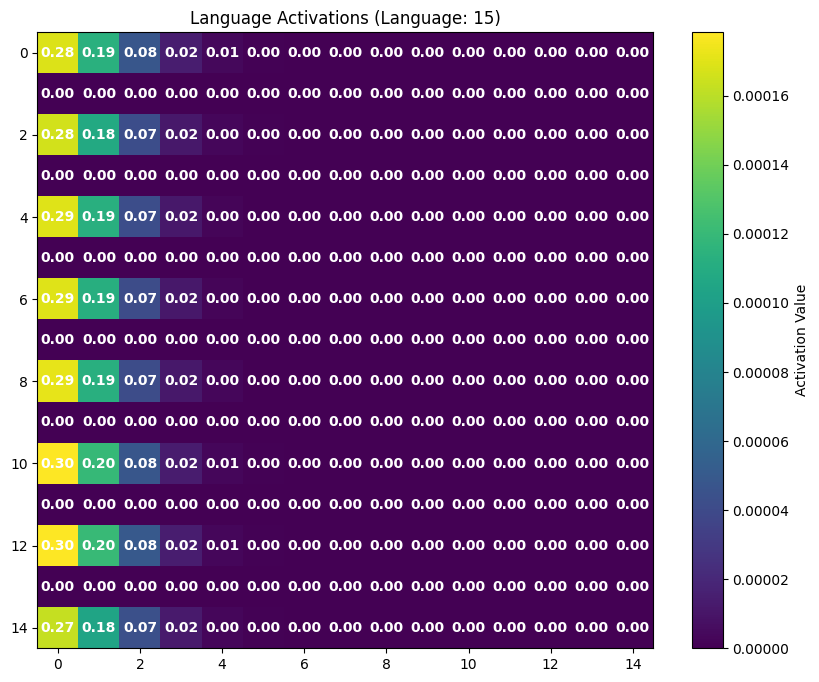

(array([[2.84504996e-01, 1.90410906e-01, 8.01912456e-02, 2.36470706e-02,
         5.93520149e-03, 1.41321235e-03, 3.78542527e-04, 1.46096773e-04,
         6.63847285e-05, 3.61818287e-05, 2.27160494e-05, 1.64043354e-05,
         1.52362494e-05, 1.71019260e-05, 1.97467331e-05],
        [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
         0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
         0.00000000e+00, 0.00000000e+00, 1.95688762e-05, 1.38642184e-05,
         1.28228550e-05, 1.49284463e-05, 1.77122642e-05],
        [2.79868436e-01, 1.82644541e-01, 7.13103911e-02, 1.98659817e-02,
         4.94871908e-03, 1.20667920e-03, 3.35226271e-04, 1.14021919e-04,
         4.94476993e-05, 2.54826689e-05, 1.58074990e-05, 1.11778421e-05,
         1.03449178e-05, 1.19265649e-05, 1.46010952e-05],
        [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
         0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
         0.00000000e+00

In [8]:
import numpy as np
import torch
import matplotlib.pyplot as plt

def getLanguageActivations(language, s_encoder, l_encoder, bias=1., plot=True):
    valid_indices = np.argwhere(maze == 0)
    unifs = np.random.uniform(0, 1, size=(100, 2))
    act_grid = np.zeros(maze.shape)
    
    with torch.no_grad():
        language_embedding = l_encoder(torch.tensor(language))
        for index in valid_indices:
            samples = unifs + index
            state_embeddings = s_encoder(torch.as_tensor(samples, dtype=torch.float32))
            dists = -torch.norm(state_embeddings - language_embedding, dim=1) * bias
            act = torch.mean(torch.exp(dists))
            act_grid[index[0], index[1]] = act
    
    if plot:
        fig, ax = plt.subplots(figsize=(10, 8))
        im = ax.imshow(act_grid, cmap='viridis')

        # Add colorbar
        cbar = plt.colorbar(im)
        cbar.set_label('Activation Value')

        # Display the values in each cell
        for i in range(act_grid.shape[0]):
            for j in range(act_grid.shape[1]):
                act_grid = act_grid / np.linalg.norm(act_grid)
                text = ax.text(j, i, f'{act_grid[i, j]:.2f}',
                               ha="center", va="center", color="w", fontweight='bold')

        plt.title(f'Language Activations (Language: {language})')
        plt.show()
    
    return act_grid,

# Assuming maze, encoder2, and encoder3 are defined elsewhere
getLanguageActivations(15, encoder2, encoder3)

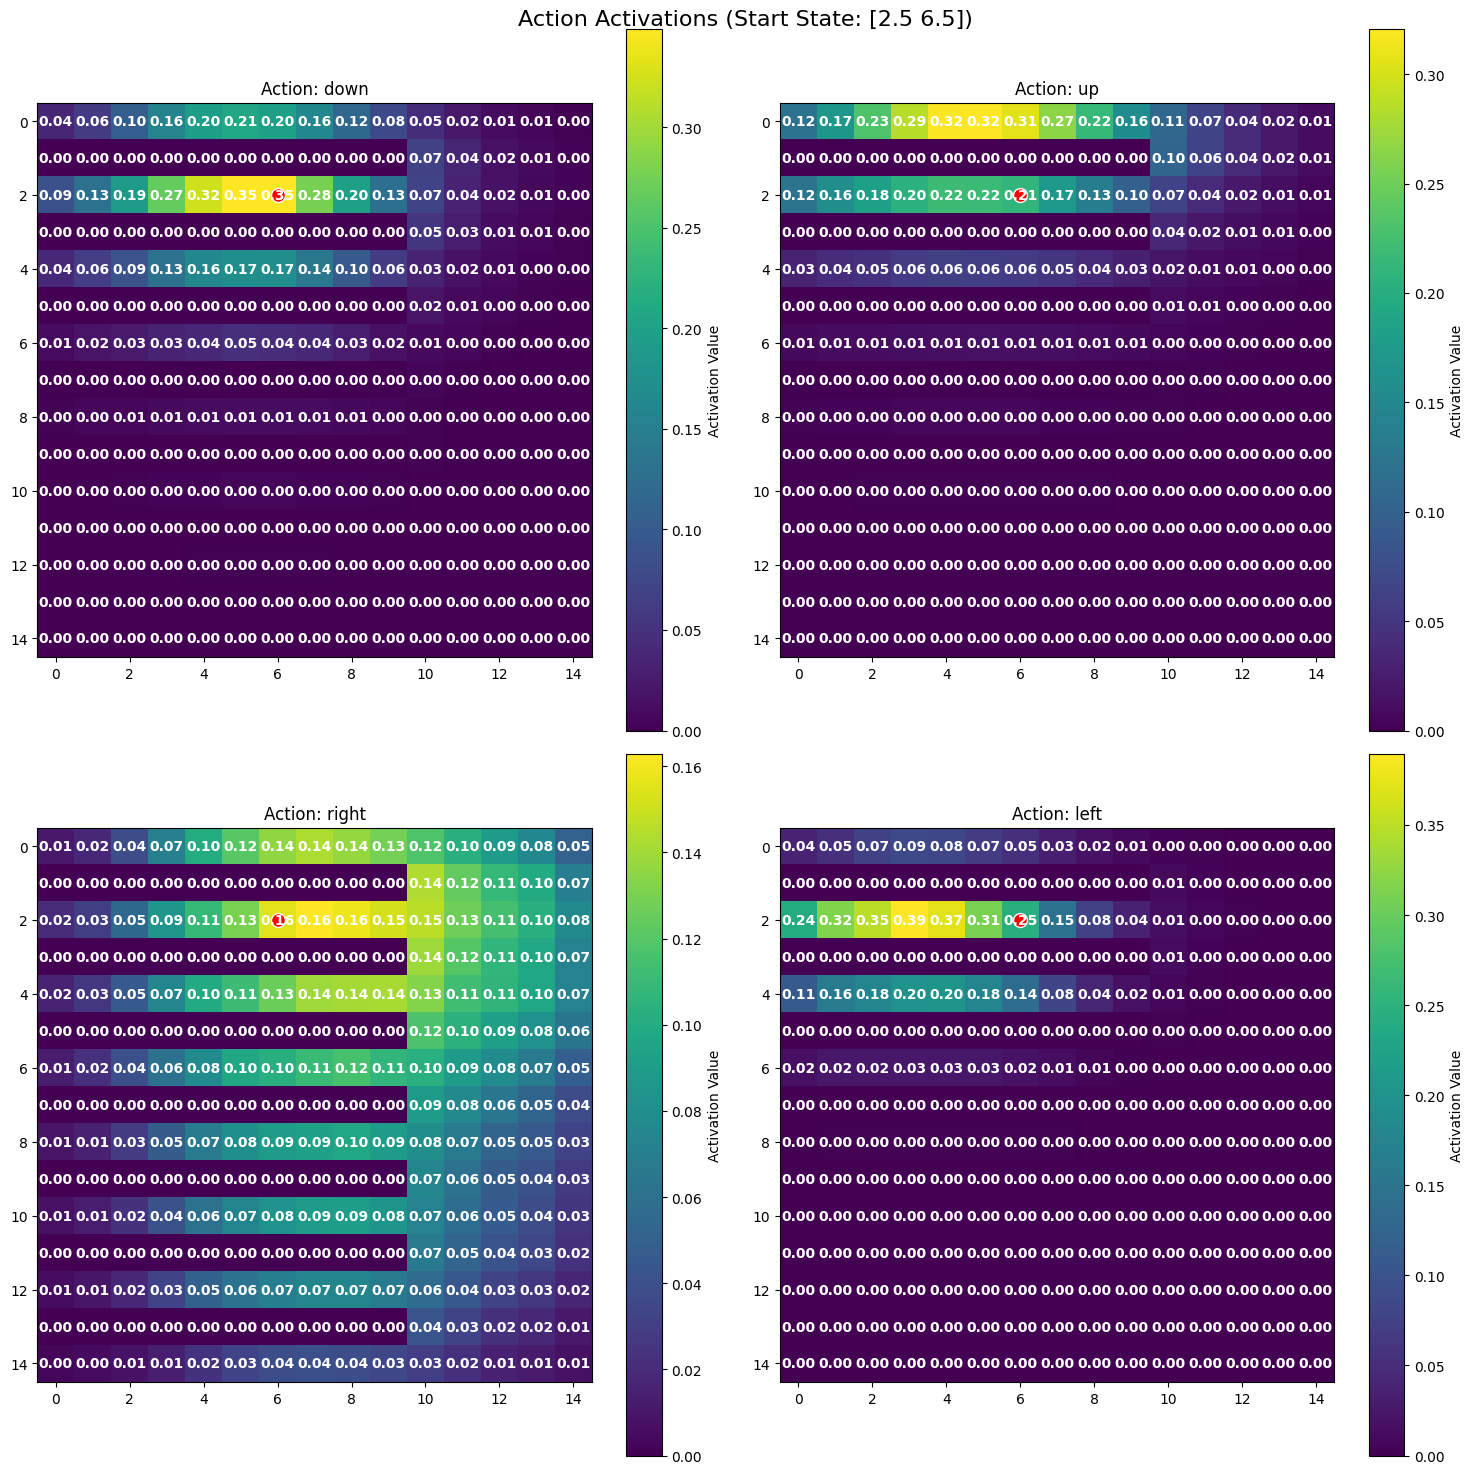

In [9]:
def getActionActivations(start_state, sa_encoder, s_encoder, plot=True):
    valid_indices = np.argwhere(maze == 0)
    unifs = np.random.uniform(0, 1, size=(100, 2))
    
    grid_dict = {}
    
    with torch.no_grad():
        actions = torch.tensor([[1., 0.], [-1., 0.], [0., 1.], [0., -1.]])
        names = ['down', 'up', 'right', 'left']
        
        if plot:
            fig, axs = plt.subplots(2, 2, figsize=(15, 15))
            fig.suptitle(f'Action Activations (Start State: {start_state.numpy()})', fontsize=16)

        for idx, (a, name) in enumerate(zip(actions, names)):
            act_grid = np.zeros(maze.shape)
            sa_embedding = sa_encoder(torch.cat([start_state, a]))
            for index in valid_indices:
                samples = unifs + index
                state_embeddings = s_encoder(torch.as_tensor(samples, dtype=torch.float32))
                dists = -torch.norm(state_embeddings - sa_embedding, dim=1) * 2.
                act = torch.mean(torch.exp(dists))
                act_grid[index[0], index[1]] = act
            
            act_grid = act_grid / np.linalg.norm(act_grid)
            grid_dict[name] = act_grid
            
            if plot:
                row = idx // 2
                col = idx % 2
                ax = axs[row, col]
                im = ax.imshow(act_grid, cmap='viridis')
                ax.set_title(f'Action: {name}')

                # Add colorbar
                cbar = fig.colorbar(im, ax=ax)
                cbar.set_label('Activation Value')

                # Display the values in each cell
                for i in range(act_grid.shape[0]):
                    for j in range(act_grid.shape[1]):
                        text = ax.text(j, i, f'{act_grid[i, j]:.2f}',
                                       ha="center", va="center", color="w", fontweight='bold')


                # Highlight the start state
                ax.plot(start_state[1] - 0.5, start_state[0] - 0.5, 'ro', markersize=10, markeredgecolor='white')

    if plot:
        plt.tight_layout()
        plt.show()
    
    return grid_dict


# Assuming maze, encoder1, and encoder2 are defined elsewhere
o = getActionActivations(torch.tensor([2.5, 6.5]), encoder1, encoder2)

In [10]:
import numpy as np
import torch
import matplotlib.pyplot as plt
import math

def getCombinedActivations(start_state, language, sa_encoder, s_encoder, l_encoder, actions=None, bias=2., plot=True):
    valid_indices = np.argwhere(maze == 0)
    unifs = np.random.uniform(0, 1, size=(100, 2))
    
    if actions is None:
        actions = torch.tensor([[1., 0.], [-1., 0.], [0., 1.], [0., -1.]])
    names = [f"[{a[0]:.2f}, {a[1]:.2f}]" for a in actions]
    
    grid_dict = {}
    
    with torch.no_grad():
        # Calculate all grids first
        for a, name in zip(actions, names):
            act_grid = np.zeros(maze.shape)
            sa_embedding = sa_encoder(torch.cat([start_state, a]))
            language_embedding = l_encoder(torch.tensor(language))
            
            for index in valid_indices:
                samples = unifs + index
                state_embeddings = s_encoder(torch.as_tensor(samples, dtype=torch.float32))
                sa_dists = -torch.norm(state_embeddings - sa_embedding, dim=1) * bias
                l_dists = -torch.norm(state_embeddings - language_embedding, dim=1) * bias
                act = torch.mean(torch.exp(sa_dists + l_dists))
                act_grid[index[0], index[1]] = act
            
            grid_dict[name] = act_grid
        
        # Find global min and max for normalization
        all_values = np.concatenate([grid.flatten() for grid in grid_dict.values()])
        global_min, global_max = np.min(all_values), np.max(all_values)
        
        # Normalize all grids
        for name in grid_dict:
            grid_dict[name] = (grid_dict[name] - global_min) / (global_max - global_min)
        
        # Calculate scores
        scores = {name: np.mean(grid) for name, grid in grid_dict.items()}
        
        # Normalize scores by mean
        mean_score = np.mean(list(scores.values()))
        normalized_scores = {name: score / mean_score for name, score in scores.items()}
        
        # Find best action
        best_action_name = max(normalized_scores, key=normalized_scores.get)
        best_action = next(a for a, name in zip(actions, names) if name == best_action_name)
        
        if plot:
            # Calculate grid size for subplots (always nx2)
            n_actions = len(actions)
            n_rows = math.ceil(n_actions / 2)
            n_cols = 2
            
            # Plot scores
            fig, ax = plt.subplots(figsize=(max(6, 0.5*n_actions), 6))
            bars = ax.bar(normalized_scores.keys(), normalized_scores.values())
            ax.set_title('Normalized Mean Activation Scores')
            ax.set_ylabel('Normalized Score (divided by mean)')
            ax.axhline(y=1, color='r', linestyle='--', label='Mean')
            ax.legend()
            
            # Highlight the best action
            best_bar = next(bar for bar, name in zip(bars, normalized_scores.keys()) if name == best_action_name)
            best_bar.set_color('green')
            
            for i, (name, score) in enumerate(normalized_scores.items()):
                ax.text(i, score, f'{score:.3f}', ha='center', va='bottom')
            
            plt.xticks(rotation=45, ha='right')
            plt.tight_layout()
            plt.show()
            
            # Plot grids
            fig, axs = plt.subplots(n_rows, n_cols, figsize=(10, 5*n_rows))
            fig.suptitle(f'Action Activations (Start State: {start_state.numpy()}, Language: {language})', fontsize=16)
            
            axs = axs.flatten()
        
            for idx, (name, act_grid) in enumerate(grid_dict.items()):
                ax = axs[idx]
                
                im = ax.imshow(act_grid, cmap='viridis', vmin=0, vmax=1)
                ax.set_title(f'Action: {name}')
                
                # Add colorbar
                cbar = fig.colorbar(im, ax=ax)
                cbar.set_label('Normalized Activation Value')
                
                # Display the normalized values in each cell
                for i in range(act_grid.shape[0]):
                    for j in range(act_grid.shape[1]):
                        text = ax.text(j, i, f'{act_grid[i, j]:.2f}',
                                       ha="center", va="center", color="w", fontweight='bold')
                
                # Highlight the start state
                ax.plot(start_state[1] - 0.5, start_state[0] - 0.5, 'ro', markersize=10, markeredgecolor='white')
            
            # Remove any unused subplots
            for idx in range(len(grid_dict), len(axs)):
                fig.delaxes(axs[idx])
            
            plt.tight_layout()
            plt.show()
            
            
    
    return grid_dict, normalized_scores, best_action



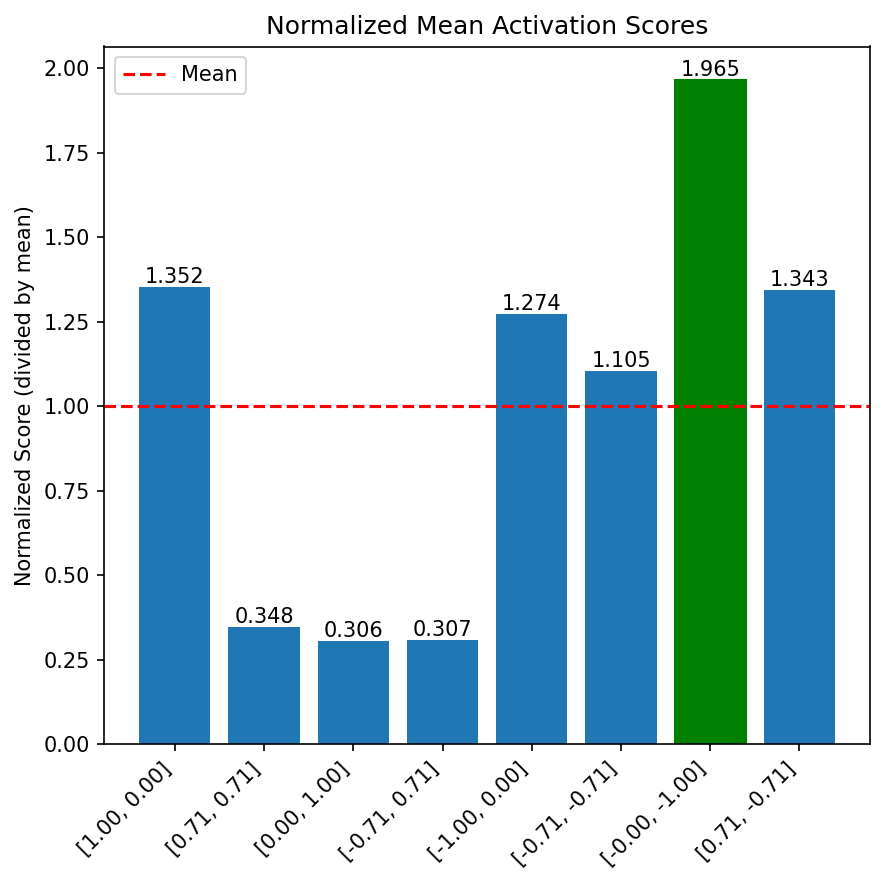

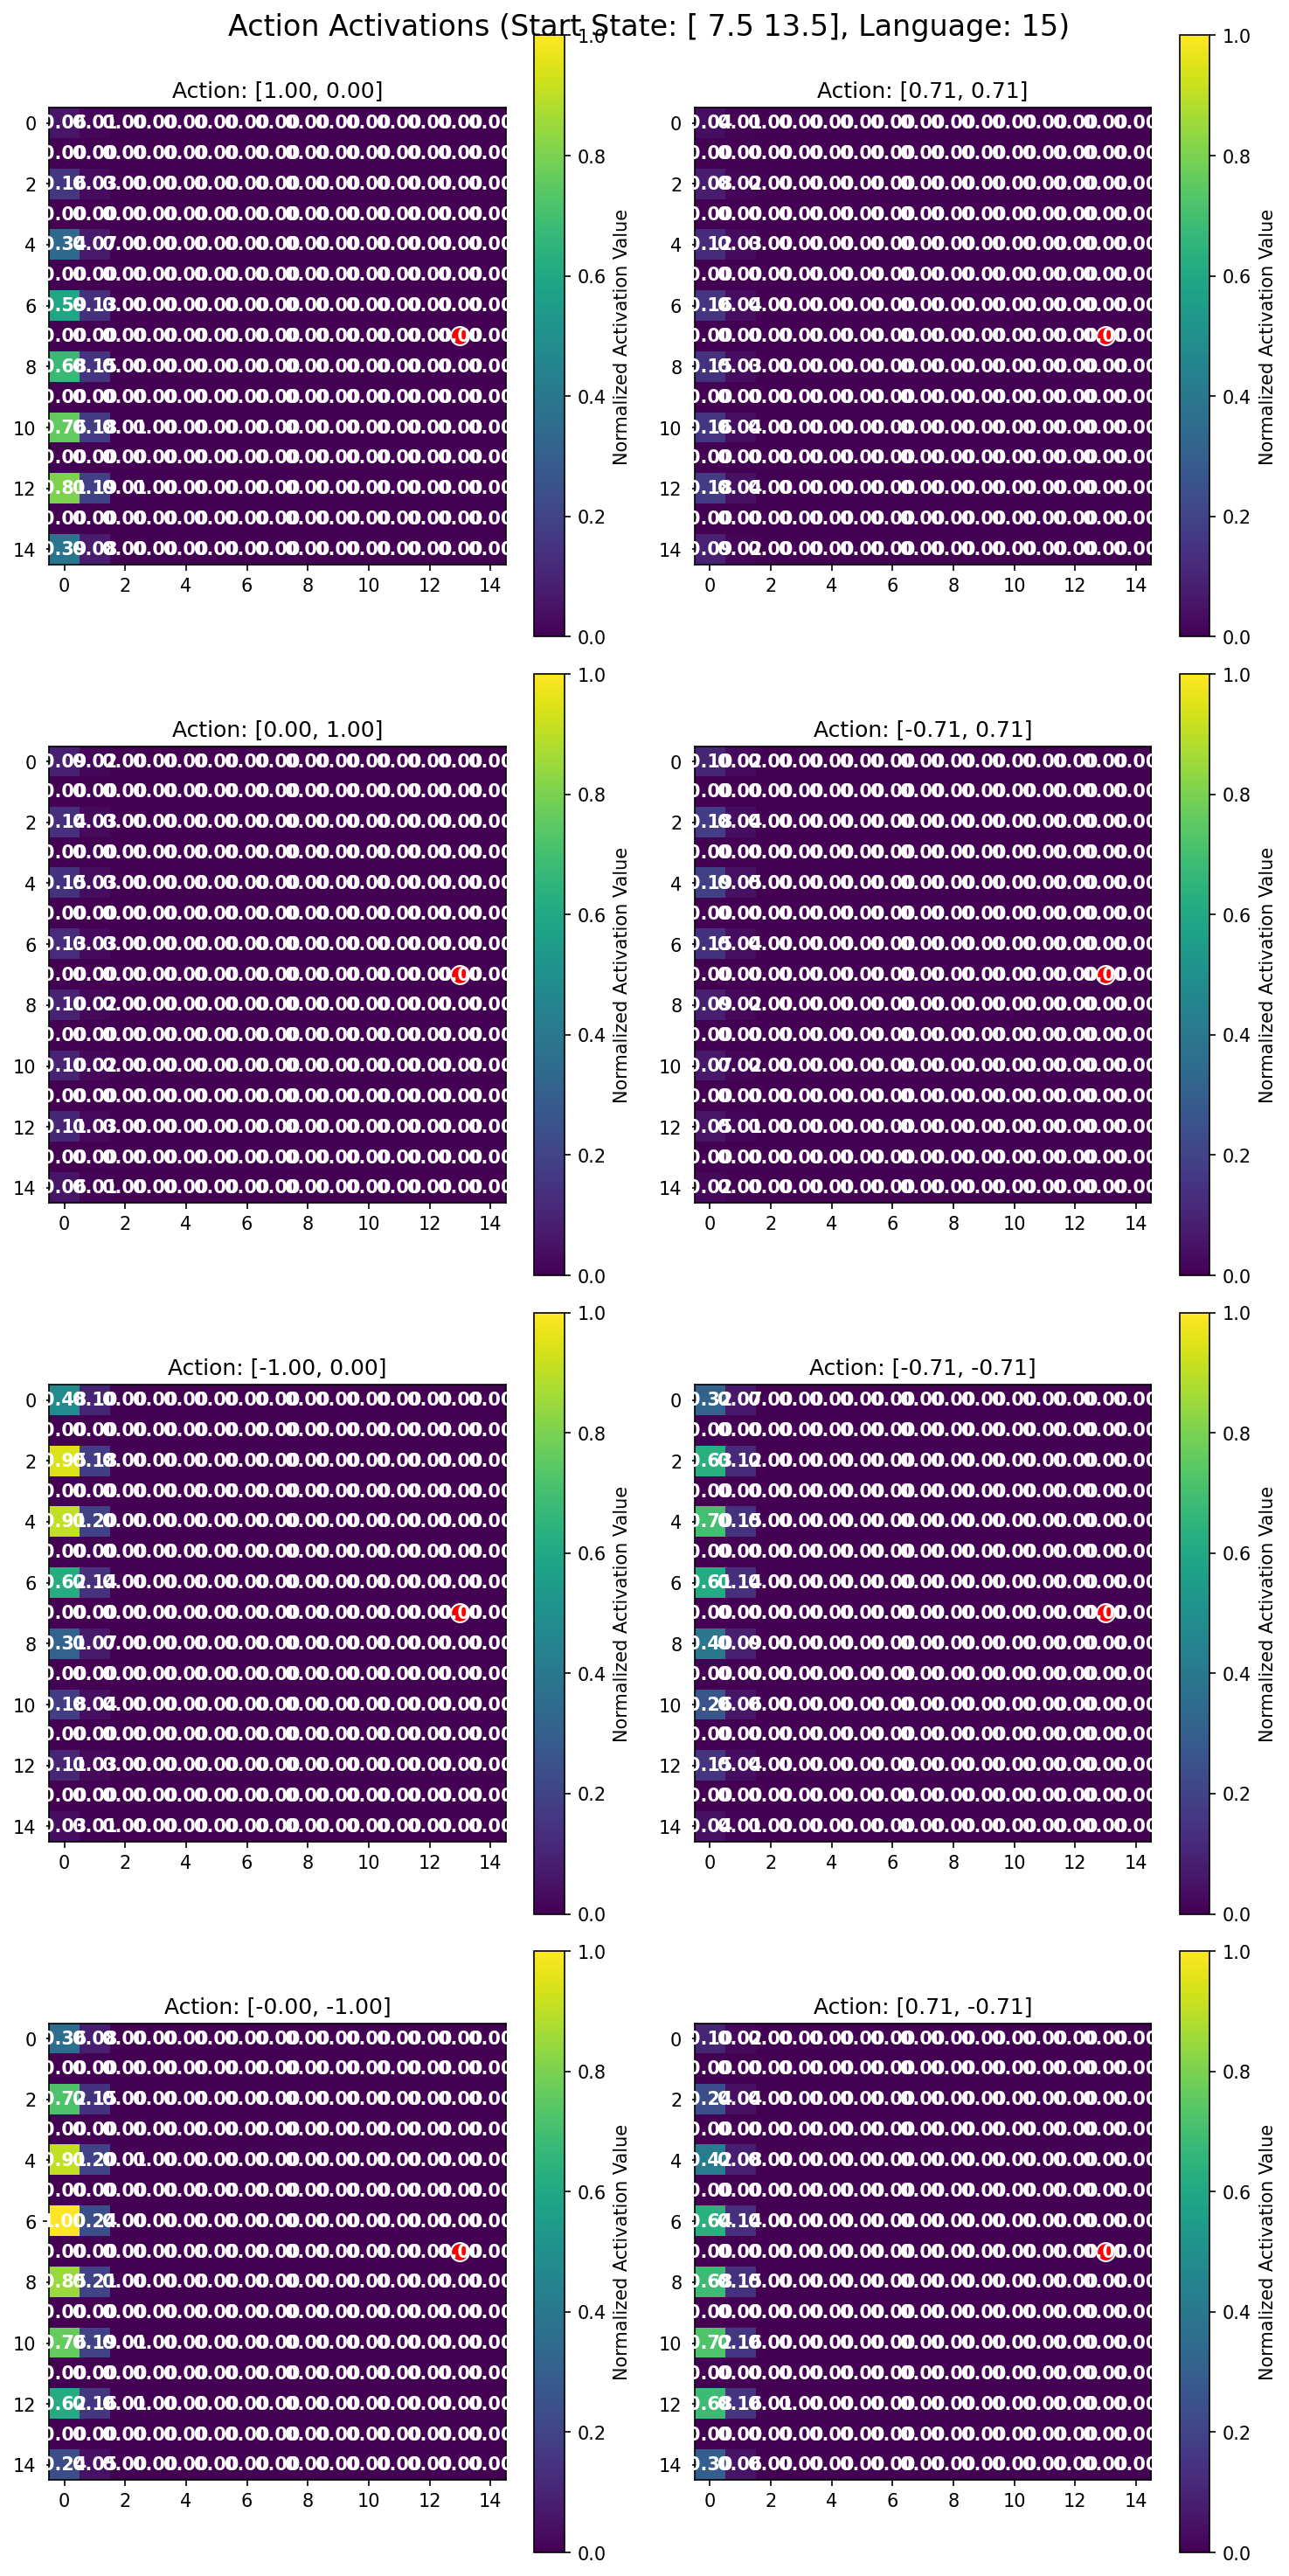

Best action: tensor([-1.8370e-16, -1.0000e+00])


In [18]:
def generate_uniform_actions(n_actions):
    angles = np.linspace(0, 2 * np.pi, n_actions, endpoint=False)
    actions = torch.tensor([[np.cos(angle), np.sin(angle)] for angle in angles], dtype=torch.float32)
    return actions

# Example usage:
n_actions = 8  # You can change this to any number of actions you want
custom_actions = generate_uniform_actions(n_actions)
o, scores, best_action = getCombinedActivations(torch.tensor([7.5, 13.5]), 15, encoder1, encoder2, encoder3, actions=custom_actions, bias=4., plot=True)
print(f"Best action: {best_action}")

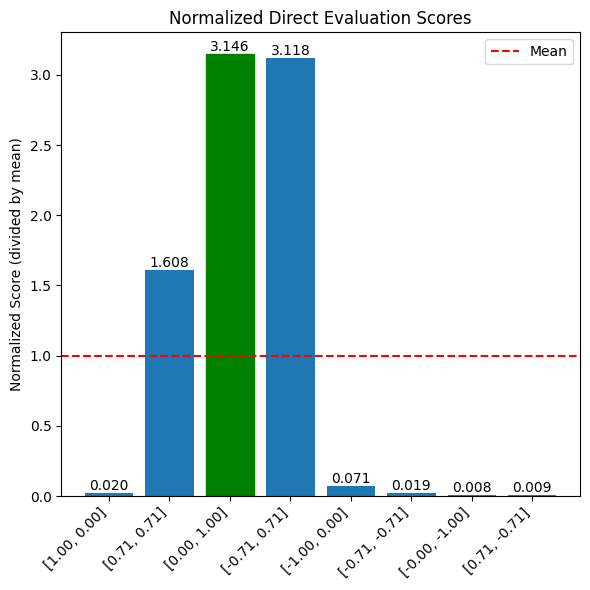

Best action: tensor([6.1232e-17, 1.0000e+00])


In [12]:
import numpy as np
import torch
import matplotlib.pyplot as plt

def getDirectEval(start_state, language, sa_encoder, l_encoder, actions=None, bias=3., plot=True):
    if actions is None:
        actions = torch.tensor([[1., 0.], [-1., 0.], [0., 1.], [0., -1.]])
    names = [f"[{a[0]:.2f}, {a[1]:.2f}]" for a in actions]
    
    scores = {}
    with torch.no_grad():
        for a, name in zip(actions, names):
            sa_embedding = sa_encoder(torch.cat([start_state, a]))
            language_embedding = l_encoder(torch.tensor(language))
            scores[name] = torch.exp(-torch.norm(sa_embedding - language_embedding))
    
    # Normalize scores by mean
    mean_score = np.mean(list(scores.values()))
    normalized_scores = {name: score / mean_score for name, score in scores.items()}
    
    # Find best action
    best_action_name = max(normalized_scores, key=normalized_scores.get)
    best_action = next(a for a, name in zip(actions, names) if name == best_action_name)
    
    if plot:
        # Plot scores
        fig, ax = plt.subplots(figsize=(max(6, 0.5*len(actions)), 6))
        bars = ax.bar(normalized_scores.keys(), normalized_scores.values())
        ax.set_title('Normalized Direct Evaluation Scores')
        ax.set_ylabel('Normalized Score (divided by mean)')
        ax.axhline(y=1, color='r', linestyle='--', label='Mean')
        ax.legend()
        
        # Highlight the best action
        best_bar = next(bar for bar, name in zip(bars, normalized_scores.keys()) if name == best_action_name)
        best_bar.set_color('green')
        
        for i, (name, score) in enumerate(normalized_scores.items()):
            ax.text(i, score, f'{score:.3f}', ha='center', va='bottom')
        
        plt.xticks(rotation=45, ha='right')
        plt.tight_layout()
        plt.show()
    
    return normalized_scores, best_action

# Example usage:
def generate_uniform_actions(n_actions):
    angles = np.linspace(0, 2 * np.pi, n_actions, endpoint=False)
    actions = torch.tensor([[np.cos(angle), np.sin(angle)] for angle in angles], dtype=torch.float32)
    return actions


start = torch.tensor([0.5, 2.5])
end = 11

n_actions = 8  # You can change this to any number of actions you want
custom_actions = generate_uniform_actions(n_actions)
scores, best_action = getDirectEval(start, end, encoder1, encoder3, actions=custom_actions, plot=True)
print(f"Best action: {best_action}")

In [13]:
def sample(maze, num_points):
    valid_indices = np.argwhere(maze == 0)
    i = np.random.randint(0, len(valid_indices), size=num_points)[:, None] # n x 1
    points = valid_indices[i].squeeze()
    noises = np.random.uniform(0, 1, size=(num_points, 2))  # n x 2
    return points + noises

print(sample(maze, 10))

def fake_encoder(points, col):
    l = []
    for point in points:
        if int(point[1]) == col:
            l.append(1)
        else:
            l.append(0)
            
    return torch.tensor(l).to(device, torch.float32)

def visualize_language(start, language, sa_encoder, s_encoder, l_encoder, LSE=False, hyperbolic=False, manifold=None, max_steps=100, eps=50, bias=4.):
    with torch.no_grad():
        start = torch.tensor(start).to(device, torch.float32)
        language = torch.tensor(language).to(device)
        
        street_embedding = l_encoder(language)

        env = ContinuousGridEnvironment(maze, start.cpu(), {})
        fig, ax = plt.subplots()

        def update(i):
            with torch.no_grad():
                n_actions = 8  # You can change this to any number of actions you want
                custom_actions = generate_uniform_actions(n_actions)
                best_action = torch.tensor([0., 0.])
                cur_pos = torch.as_tensor(env.agent_position, dtype=torch.float32)
                if LSE:
                    o, scores, best_action = getCombinedActivations(cur_pos, language, sa_encoder, s_encoder, l_encoder, actions=custom_actions, plot=False, bias=bias)
                else:
                    scores, best_action = getDirectEval(torch.tensor(cur_pos), language, sa_encoder, l_encoder, actions=custom_actions, plot=False)
                
                angle = np.arctan2(best_action[0], best_action[1]) + np.random.normal() * eps * (2 * np.pi / 360)
                best_action = torch.tensor(np.array([np.sin(angle), np.cos(angle)]))
                env.move_agent(best_action)
                # print(f'agent position: {env.agent_position}')
                ax.clear()
                env.display(ax=ax)

        # Set animation display in Jupyter notebook and figure resolution
        plt.rcParams["animation.html"] = "jshtml"
        plt.rcParams['figure.dpi'] = 150

        # Create the animation
        ani = FuncAnimation(fig, update, frames=max_steps, interval=max_steps, repeat=False)

    return ani

[[ 6.83325763 14.35724058]
 [ 2.65914659  9.69153918]
 [ 8.62591549  6.56963924]
 [ 4.95755567 13.27992355]
 [ 0.14901489  1.83690927]
 [ 3.85482668 11.71964711]
 [ 4.3519008   9.05061601]
 [ 9.15466816 13.33511283]
 [12.87412156  3.98245991]
 [ 4.3126028   6.35648004]]


In [14]:
def reached_language(maze, position, language):
    pos0 = int(position[0])
    pos1 = int(position[1])
    
    if language >= maze.shape[0]:
        return ((language - maze.shape[0]) == pos1)
    else:
        return (language == pos0)
    
    
def benchmark_language(start, language, sa_encoder, s_encoder, l_encoder, num_trials=1, LSE=False, hyperbolic=False, manifold=None, max_steps=100, eps=50, bias=4.):
    with torch.no_grad():
        start = torch.tensor(start).to(device, torch.float32)
        language = torch.tensor(language).to(device)
        
        street_embedding = l_encoder(language)

        
        trials = []
        successes = []
        
        for _ in range(num_trials):
            env = ContinuousGridEnvironment(maze, start.cpu(), {})
            steps = 0

            while not reached_language(maze, env.agent_position, language):
                with torch.no_grad():
                    n_actions = 8  # You can change this to any number of actions you want
                    custom_actions = generate_uniform_actions(n_actions)
                    best_action = torch.tensor([0., 0.])
                    cur_pos = torch.as_tensor(env.agent_position, dtype=torch.float32)
                    if LSE:
                        o, scores, best_action = getCombinedActivations(cur_pos, language, sa_encoder, s_encoder, l_encoder, actions=custom_actions, plot=False, bias=bias)
                    else:
                        scores, best_action = getDirectEval(torch.tensor(cur_pos), language, sa_encoder, l_encoder, actions=custom_actions, plot=False)
                    angle = np.arctan2(best_action[0], best_action[1]) + np.random.normal() * eps * (2 * np.pi / 360)
                    best_action = torch.tensor(np.array([np.sin(angle), np.cos(angle)]))
                    env.move_agent(best_action)
                steps += 1
                
                if steps > max_steps:
                    break
                    
            if reached_language(maze, env.agent_position, language):
                successes.append(1)
            else:
                successes.append(0)
    
            trials.append(steps)
        
        if num_trials == 1:
            return successes[0], trials[0]
        
        return successes, trials

benchmark_language(start, end, encoder1, encoder2, encoder3, num_trials=1, hyperbolic=False, manifold=None, max_steps=50, LSE=True)




/tmp/ipykernel_2489517/3410597526.py:13: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  start = torch.tensor(start).to(device, torch.float32)
/tmp/ipykernel_2489517/3667200560.py:21: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  language_embedding = l_encoder(torch.tensor(language))


(0, 51)

In [183]:
benchmark_language(start, end, encoder1, encoder2, encoder3, num_trials=10, hyperbolic=False, manifold=None, max_steps=50, LSE=True)

/tmp/ipykernel_2536840/3388603469.py:13: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  start = torch.tensor(start).to(device, torch.float32)
/tmp/ipykernel_2536840/3667200560.py:21: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  language_embedding = l_encoder(torch.tensor(language))


[17, 14, 18, 21, 11, 14, 13, 12, 14, 16]

In [182]:
benchmark_language(start, end, encoder1, encoder2, encoder3, num_trials=10, hyperbolic=False, manifold=None, max_steps=50, LSE=False)

/tmp/ipykernel_2536840/3388603469.py:13: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  start = torch.tensor(start).to(device, torch.float32)
/tmp/ipykernel_2536840/3388603469.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  scores, best_action = getDirectEval(torch.tensor(cur_pos), language, sa_encoder, l_encoder, actions=custom_actions, plot=False)
/tmp/ipykernel_2536840/184873771.py:14: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  language_embedding = l_encoder(torch.tensor(language))


[26, 26, 26, 26, 26, 26, 26, 26, 26, 26]

trial 0


/tmp/ipykernel_2489517/3410597526.py:35: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  scores, best_action = getDirectEval(torch.tensor(cur_pos), language, sa_encoder, l_encoder, actions=custom_actions, plot=False)
/tmp/ipykernel_2489517/2588372164.py:14: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  language_embedding = l_encoder(torch.tensor(language))
/tmp/ipykernel_2489517/3667200560.py:21: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  language_embedding = l_encoder(torch.tensor(language))


trial 1
trial 2
trial 3
trial 4
trial 5
trial 6
trial 7
trial 8
trial 9
trial 10
trial 11
trial 12
trial 13
trial 14
trial 15
trial 16
trial 17
trial 18
trial 19
trial 20
trial 21
trial 22
trial 23
trial 24
trial 25
trial 26
trial 27
trial 28
trial 29
trial 30
trial 31
trial 32
trial 33
trial 34
trial 35
trial 36
trial 37
trial 38
trial 39
trial 40
trial 41
trial 42
trial 43
trial 44
trial 45
trial 46
trial 47
trial 48
trial 49
Results:
Average Naive Length: 44.76
Average LSE Length: 25.54
Naive Success Rate: 16.00%
LSE Success Rate: 84.00%


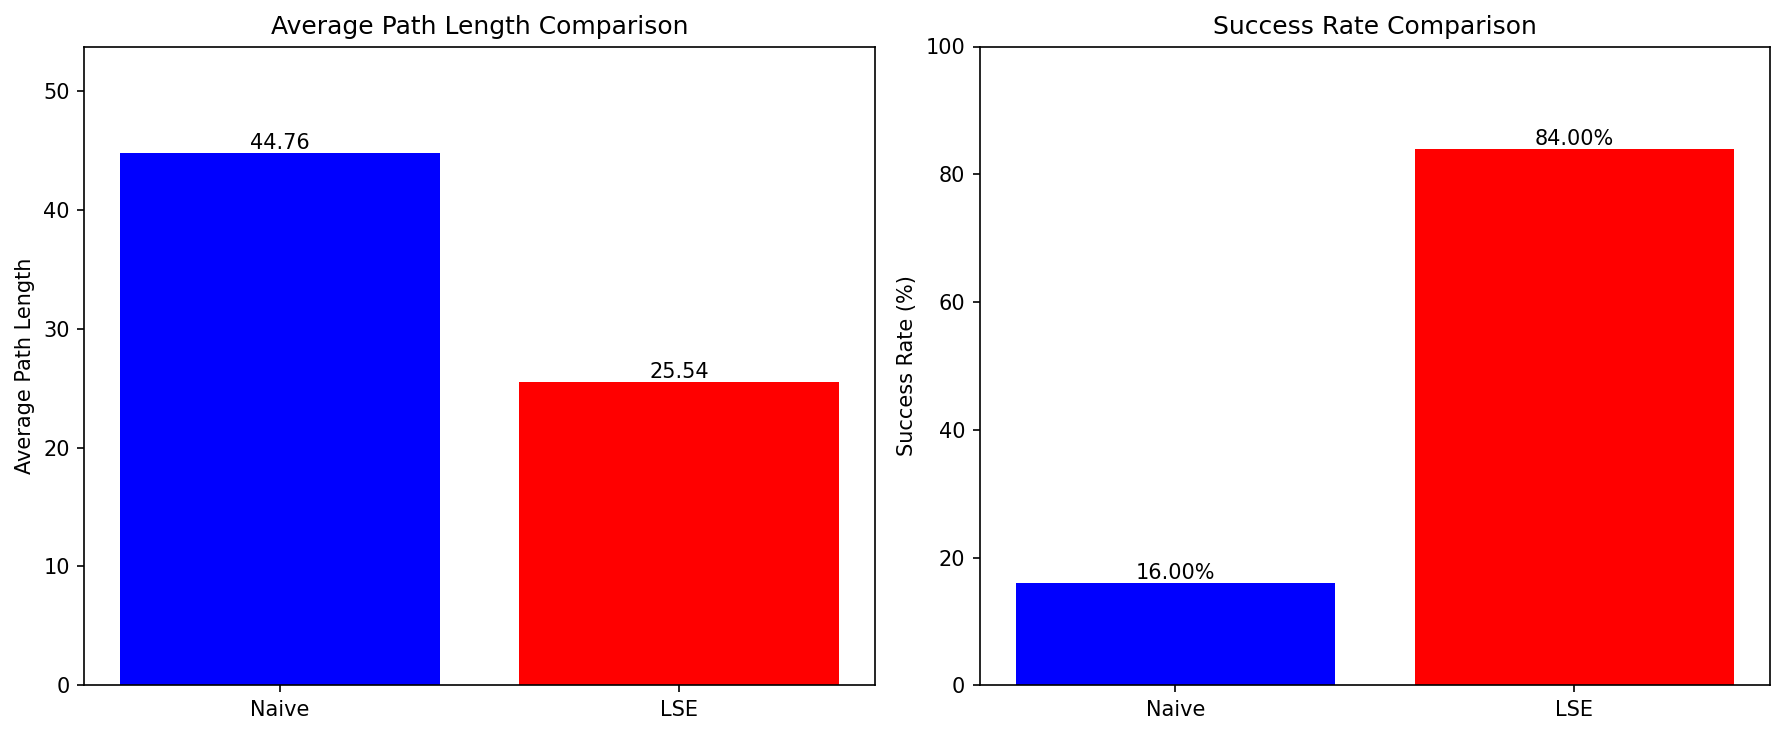

In [19]:
import numpy as np
import matplotlib.pyplot as plt

NUM_TRIALS = 50
bias = 4.
total_naive_len = 0.
total_lse_len = 0.
total_naive_suc = 0
total_lse_suc = 0
naive_results = []
lse_results = []

for i in range(NUM_TRIALS):
    print(f'trial {i}')
    valid_indices = np.argwhere(maze == 0)
    start = valid_indices[np.random.randint(0, len(valid_indices))]
    end = np.random.randint(0, 22)
    
    # start = torch.tensor([2.5, 6.5])
    end = 11
    
    suc_naive, len_naive = benchmark_language(start, end, encoder1, encoder2, encoder3, num_trials=1, hyperbolic=False, manifold=None, max_steps=50, LSE=False, bias=bias)
    suc_lse, len_lse = benchmark_language(start, end, encoder1, encoder2, encoder3, num_trials=1, hyperbolic=False, manifold=None, max_steps=50, LSE=True)

    total_naive_len += len_naive
    total_lse_len += len_lse
    total_naive_suc += suc_naive
    total_lse_suc += suc_lse
    
    naive_results.append(len_naive)
    lse_results.append(len_lse)

avg_naive_len = total_naive_len / NUM_TRIALS
avg_lse_len = total_lse_len / NUM_TRIALS
success_rate_naive = total_naive_suc / NUM_TRIALS * 100
success_rate_lse = total_lse_suc / NUM_TRIALS * 100

print('Results:')
print(f'Average Naive Length: {avg_naive_len:.2f}')
print(f'Average LSE Length: {avg_lse_len:.2f}')
print(f'Naive Success Rate: {success_rate_naive:.2f}%')
print(f'LSE Success Rate: {success_rate_lse:.2f}%')

# Bar plots
methods = ['Naive', 'LSE']
avg_lengths = [avg_naive_len, avg_lse_len]
success_rates = [success_rate_naive, success_rate_lse]
colors = ['blue', 'red']

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))

# Average Path Length plot
rects1 = ax1.bar(methods, avg_lengths, color=colors)
ax1.set_ylabel('Average Path Length')
ax1.set_title('Average Path Length Comparison')
ax1.set_ylim(0, max(avg_lengths) * 1.2)  # Set y-limit with 20% headroom

# Success Rate plot
rects2 = ax2.bar(methods, success_rates, color=colors)
ax2.set_ylabel('Success Rate (%)')
ax2.set_title('Success Rate Comparison')
ax2.set_ylim(0, 100)  # Set y-limit to 100% for success rate

# Add text for scores
for ax, rects in zip([ax1, ax2], [rects1, rects2]):
    for rect in rects:
        height = rect.get_height()
        ax.text(rect.get_x() + rect.get_width()/2., height,
                f'{height:.2f}{"%" if ax == ax2 else ""}',
                ha='center', va='bottom')

fig.tight_layout()
plt.show()

/tmp/ipykernel_2489517/656844986.py:22: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  start = torch.tensor(start).to(device, torch.float32)
/tmp/ipykernel_2489517/3667200560.py:21: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  language_embedding = l_encoder(torch.tensor(language))


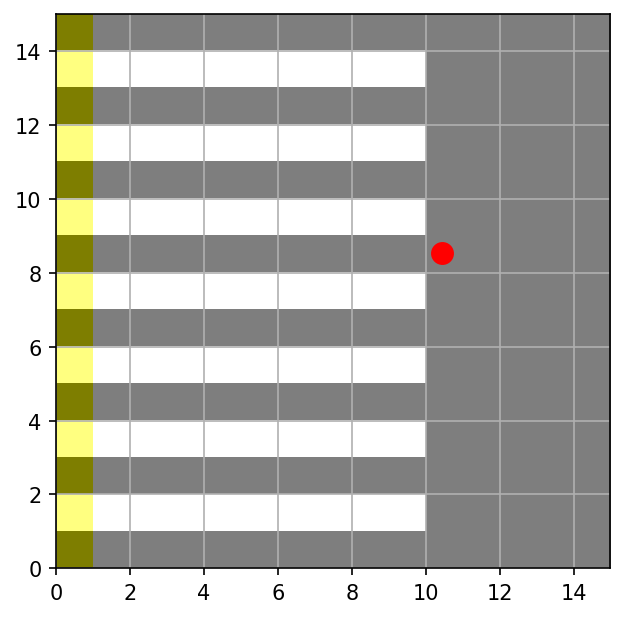

In [16]:
start = torch.tensor([7.5, 13.5])
end = 15

visualize_language(start, end, encoder1, encoder2, encoder3, hyperbolic=False, manifold=None, max_steps=100, LSE=True, bias=4.)


/tmp/ipykernel_2489517/656844986.py:22: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  start = torch.tensor(start).to(device, torch.float32)
/tmp/ipykernel_2489517/656844986.py:39: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  scores, best_action = getDirectEval(torch.tensor(cur_pos), language, sa_encoder, l_encoder, actions=custom_actions, plot=False)
/tmp/ipykernel_2489517/2588372164.py:14: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  language_embedding = l_encoder(torch.tensor(language))


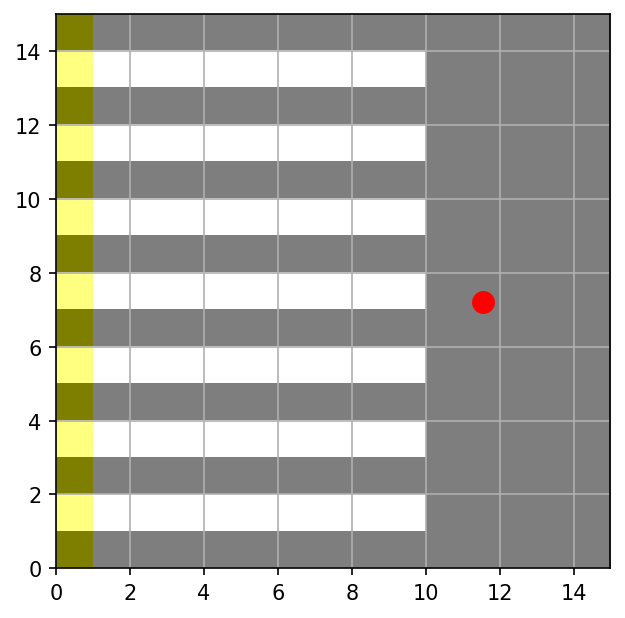

In [17]:
visualize_language(start, end, encoder1, encoder2, encoder3, hyperbolic=False, manifold=None, max_steps=100, LSE=False)